In [68]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [69]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

In [70]:
train_set = datasets.MNIST('./data/train', download=True, train=True, transform=transform)
val_set = datasets.MNIST('./data/val', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

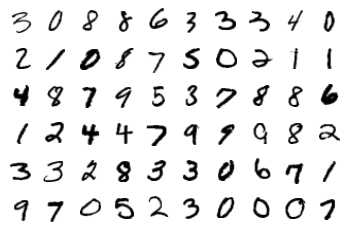

In [71]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [72]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

In [74]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))
print("Training Time =",(time()-time0)/60)

Epoch 0 - Training loss: 0.24347518716873265
Epoch 1 - Training loss: 0.19528674042380567
Epoch 2 - Training loss: 0.1620550036454188
Epoch 3 - Training loss: 0.13877167582098862
Epoch 4 - Training loss: 0.12096592514757822
Epoch 5 - Training loss: 0.10611524820220528
Epoch 6 - Training loss: 0.09579035448236094
Epoch 7 - Training loss: 0.0854082862957756
Epoch 8 - Training loss: 0.0775437657627017
Epoch 9 - Training loss: 0.07145556411755555
Epoch 10 - Training loss: 0.06663545808826349
Epoch 11 - Training loss: 0.060400813088954876
Epoch 12 - Training loss: 0.05621236670406849
Epoch 13 - Training loss: 0.05214095906119174
Epoch 14 - Training loss: 0.04708320428547797
Training Time = 4.604708627859751


In [75]:
correct_count, all_count = 0, 0
for images, labels in val_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
print("Accuracy =", (correct_count / all_count))

Accuracy = 0.9731


In [77]:
with torch.no_grad():
    print(torch.exp(model(images[2].view(1, 784))))

tensor([[1.2991e-10, 9.9971e-01, 7.4206e-06, 1.3807e-06, 1.9843e-05, 1.2631e-09,
         1.9168e-06, 7.6767e-05, 1.7707e-04, 2.4960e-06]])


In [79]:
model.eval()
traced_script_module = torch.jit.trace(model, images[2].view(1, 784))
traced_script_module.save("./traced_model.pt")

In [81]:
torch.exp(traced_script_module(images[0].view(1, 784)))

tensor([[9.9996e-01, 3.0131e-08, 3.6943e-05, 1.1377e-07, 1.9078e-09, 7.9557e-09,
         3.0201e-06, 9.8770e-07, 4.7091e-10, 1.6599e-07]],
       grad_fn=<ExpBackward>)